## Scrape and Predict Car Prices

In [35]:
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import urllib2
import pandas as pd
import re
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_random_state
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

### Getting the data

In [2]:
url = "http://listado.tucarro.com.co/carros/chevrolet/aveo/"
body = urllib2.urlopen(url).read()
response = HtmlResponse(url=url,body=body)


In [3]:
print response.xpath('//title/text()').extract()[0]

Carros, Camionetas y Camperos Chevrolet Aveo - TuCarro Colombia


In [4]:
def get_cars(response):
    cars = response.xpath('//li[@class="article"]')
    names = [ car.xpath('.//a/text()').extract()[0] for car in cars]
    prices = [ car.xpath('.//span[@class="ch-price"]/text()').extract()[0] for car in cars]
    usage = [car.xpath('.//li[@class="destaque"]/strong/text()').extract() for car in cars]
    return pd.DataFrame({'name' : names, 'price' : prices , 'year' : [x[0] for x in usage],'kms' : [x[1] for x in usage]})

In [5]:
limit = 20
count = 1
df = get_cars(response)
print "fetching for url",url
while True:
    if count >= limit:
        break
        
    new_url = response.xpath('//li[@class="last-child"]/a').xpath('@href').extract()
    if(len(new_url)==0):
        break
    print "fetching for url",new_url[0]    
    response = HtmlResponse(url=new_url[0],body= urllib2.urlopen(new_url[0]).read())
    df = df.append(get_cars(response))
    count +=1

fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_49
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_97
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_145
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_193
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_241
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_289
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_337
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_385
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_433
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_481
fetching for url http://listado.tucarro.com.co/carros/chevrolet/aveo/_Desde_529
fetching for url http://listado.tucarro.com.co/carro

In [6]:
df.to_csv('cars.csv',encoding='utf-8',index=False)

In [6]:
df.head()

,kms,name,price,year
0,51.000 Km,Chevrolet Aveo Family Mt 1500cc 4p Aa,$ 20.500.000,2013
1,73.000 Km,Chevrolet Aveo,$ 18.800.000,2010
2,76.000 Km,Chevrolet Aveo Family Mt 1600cc 4p Aa,$ 17.000.000,2008
3,41.500 Km,Chevrolet Aveo Emotion 1.6l Mt Aa 1ab,$ 21.500.000,2010
4,57.300 Km,Chevrolet Aveo,$ 14.700.000,2008


In [7]:
df['kms']= df['kms'].apply(lambda x : re.sub("[^0-9]","", x)).astype(float)

In [8]:
df['price'] = df['price'].apply(lambda y : re.sub("[^0-9]","", y)).astype(float)

In [9]:
df['year']=df['year'].astype(int)

In [10]:
df['price'] = df['price'] / 1000000 

In [11]:
df.describe()

,kms,price,year
count,789.000000,789.000000,789.000000
mean,64032.068441,18.473920,2009.799747
std,30095.079778,2.830945,2.005184
min,4500.000000,13.300000,2006.000000
25%,42000.000000,16.400000,2008.000000
50%,60000.000000,18.000000,2010.000000
75%,79300.000000,20.300000,2012.000000
max,200000.000000,32.000000,2014.000000


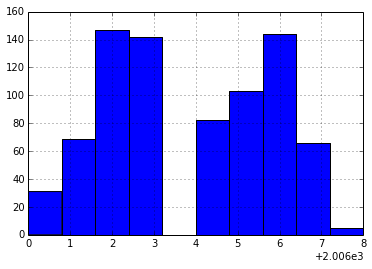

In [28]:
df['year'].hist()

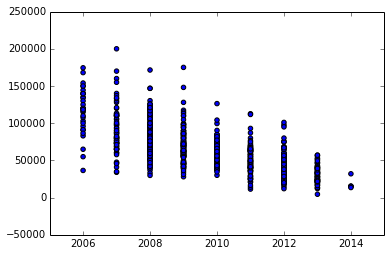

In [45]:
plt.scatter(df['year'],df['kms'])

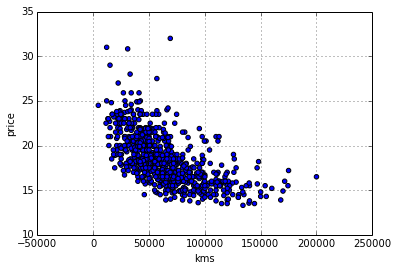

In [33]:
df.plot(kind='scatter',x='kms',y='price')

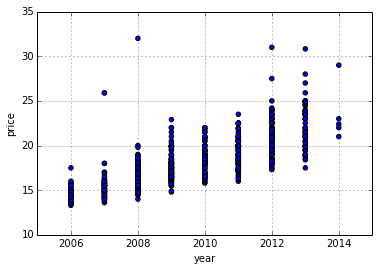

In [32]:
df.plot(kind='scatter',x='year',y='price')

In [51]:
target = "price"
y = df[target]
X = df.drop([target,'name','kms'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=3)

clf = linear_model.LinearRegression()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [52]:
print "r^2 score ",r2_score(y_test, y_pred)
print "rmse ",np.sqrt(mean_squared_error(y_test, y_pred))

r^2 score  0.629428136832
rmse  1.66945825015


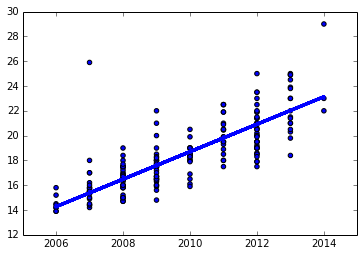

In [55]:
plt.scatter(X_test,y_test)
plt.plot(X_test, y_pred, color='blue',
         linewidth=3)

In [48]:
target = "price"
y = df[target]
X = df.drop([target,'name'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=3)

clf = linear_model.LinearRegression()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [49]:
print "r^2 score ",r2_score(y_test, y_pred)

r^2 score  0.640888950113


In [50]:
print "rmse ",np.sqrt(mean_squared_error(y_test, y_pred))

rmse  1.64343952061


In [23]:
zip(['kms','year'],list(clf.coef_))

[('kms', -1.6007228665470935e-05), ('year', 0.93540576440096379)]

In [24]:
clf.intercept_ 

-1860.481927495325

In [25]:
clf.predict(pd.DataFrame({'kms' : [100000,200000,3000],'year' : [2006,2006,2011]}))

array([ 14.34131303,  12.74059016,  20.57104303])